# Определение возраста покупателей

## Исследовательский анализ данных

### Описание проекта

Гипермаркет внедряет систему компьютерного зрения для анализа фотографий покупателей в прикассовой зоне. Это позволит определять возраст клиентов с целью анализа их покупок, предлагая товары, которые могут заинтересовать покупателей той или иной возрастной группы. Также система будет использоваться для контроля добросовестности кассиров при продаже алкоголя. Для достижения этой цели необходимо разработать модель, способную определить приблизительный возраст человека по его фотографии. Планируется использовать набор фотографий людей с указанием их возраста, провести исследовательский анализ данного набора, подготовить данные к обучению, обучить нейронную сеть и оценить ее качество.

### Часть 1

Проведем исследовательский анализ данных:

Построим график распределения возраста в выборке.
Выведем на экран 10–15 фотографий и посмотрим, как устроен датасет.
Затем сделаем выводы о том, как результаты исследования повлияют на обучение модели.

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import defaultdict

Размер выборки: 7591


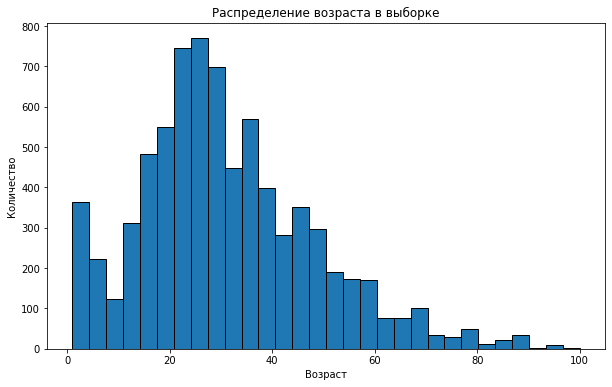

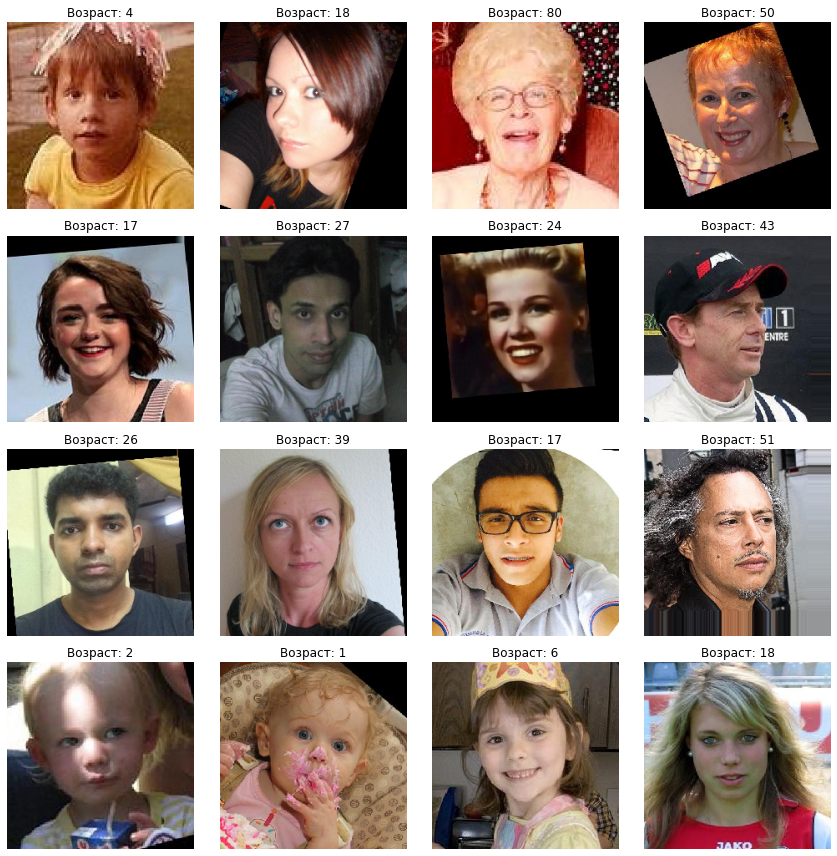

In [ ]:
# загрузим CSV-файл с данными
data = pd.read_csv('/datasets/faces/labels.csv')

# выведем размер выборки
print("Размер выборки:", len(data))

# построим график распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(data['real_age'], bins=30, edgecolor='k')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

# создадим фигуру с 4 столбцами и 4 строками для удобного вывода картинок
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# отобразим 16 фотографий, для ознакомления
for i in range(16):
    file_name = '/datasets/faces/final_files/' + data['file_name'][i]
    img = image.load_img(file_name, target_size=(224, 224))

    # расположим изображения в нужной ячейке
    row, col = divmod(i, 4)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Возраст: {data['real_age'][i]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# выведем статистические характеристики
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
# выведем названия файлов
print(data)

       file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]


In [ ]:
# проверим датасет на дубли и битые файлы
def find_duplicates(directory):
    # создадим словарь для хранения хэшей изображений и списков файлов с одинаковыми хэшами
    image_hashes = defaultdict(list)

    # пройдем по всем файлам в указанной директории
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            try:
                # откроем изображение
                with Image.open(file_path) as img:
                    # вычислим хэш для содержимого изображения
                    image_hash = hash(img.tobytes())
                    # добавим файл в соответствующий список по хэшу
                    image_hashes[image_hash].append(file_path)
            except (OSError, Image.DecompressionBombError):
                # обработаем ошибки чтения изображений и выводем сообщения об ошибке
                print(f"Ошибка при обработке файла: {filename}")

    # выведем информацию о дубликатах
    for hash_value, files in image_hashes.items():
        if len(files) > 1:
            # если есть более одного файла с одним хэшем, то это дубликаты
            print(f'Дубликаты (hash={hash_value}):')
            for file_path in files:
                print(file_path)

find_duplicates('/datasets/faces/final_files/')

Дубликаты (hash=8138202218587160404):
/datasets/faces/final_files/001601.jpg
/datasets/faces/final_files/005998.jpg


In [ ]:
# выведем размерность картинок
from PIL import Image

# путь к изображению
file_path = '/datasets/faces/final_files/000003.jpg'

# откроем изображение
with Image.open(file_path) as img:
    # получим размер изображения
    width, height = img.size
    print(f"Ширина: {width} пикселей, Высота: {height} пикселей")

Ширина: 370 пикселей, Высота: 370 пикселей


### Вывод по части 1

*** Описание фотографий ***

Субъекты фотографий:

- Люди разных возрастов.
- Люди разных расс и цвета кожи.
- Люди разных полов.

Позы и лицо:

- Фотографии лиц.
- Фотографии человека полностью.
- Анфас, где люди смотрят прямо в объектив.
- Лицо повернуто в сторону и взгляд направлен мимо камеры.

Кадрирование:

- Фотографии, где лицо полностью в кадре.
- Фотографии с кропом, где лицо не помещается в кадр.

Аугментация:

- Фотографии, повернутые от вертикали, с черными углами.

Фоны:

- Фото на однотонном фоне.
- Фото с разным фоном.

Выражение лица:
    
- Фотографии с разным выражением лица.

Качество изображения:
    
- Фотографии с хорошим качеством, где лицо четко видно.
- Фотографии с плохим качеством, например, с тенями на лице.

Аксессуары:
    
- Наличие очков или головных уборов на некоторых фотографиях.
- Наличие или отсутствие других элементов одежды в кадре

Особенности:
    
- На фотографиях детей, иногда, часть лица закрыта рукой, и лицо испачкано.
- Фотографии, на которых нет лица и сложно разглядеть человека.
- Разная освещенность на фотографиях, от очень темных до очень светлых.
- Присутствуют черно-белые снимки
    
    

***Размер выборки:***

В нашем датасете содержится 7591 фотография. Этого количества, вероятно, будет достаточно для выполнения задачи по определению возраста.

***Анализ возраста на фотографиях:***

Основное количество людей на фотографиях находится в возрастной группе от 20 до 41 лет. Это отражает естественное распределение возрастов в социальных сетях и фотоальбомах.
Гистограмма фотографий показывает смещение в сторону молодых и среднего возраста людей. Существенное уменьшение числа фотографий после 60 лет и особенно после 80 лет.
Дисбаланс классов: Из анализа возраста на фотографиях можно сделать вывод, что дисбаланс классов может быть ожидаемым и не всегда требует коррекции. Поэтому мы пропустим коррекцию дисбаланса и попробуем построить модель на имеющихся данных.

***Дубликаты в датасете:***

В датасете обнаружены всего 2 одинаковые фотографии из более чем 7000. Для целей этой задачи оставим их без изменений.
Также в датасете есть фотографии низкого качества и с недостатками, такие как ухудшенное освещение и частично закрытые лица. Мы решаем оставить такие фотографии, поскольку хотим, чтобы наша нейросеть справлялась с задачей определения возраста, несмотря на эти недостатки.

***Аугментация данных:***

В данной ситуации содержит аугментированные фотографии со смещениями и поворотами. Поэтому проведем аугментацию данных, выполнив горизонтальное отражение.

***Размер фотографий:***

В результате проверки размера фотографий, установлено, что все фотографии имеют одинаковый размер: ширина - 370 пикселей и высота - 370 пикселей.

Таким образом, мы подготовили датасет и учли его особенности для последующего обучения модели на фотографиях для определения возраста.

Проведя данное исследование, мы можем полагать, что нам удастся обучить модель, так как данные содержащиеся в датасете в целом нас устраивают. Однако, если качество модели получится недостаточно высоким, мы снова обратимся к нашему описанию данных и сразу сможем повлиять на недостатки датасета, которые мы описали выше.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import defaultdict

def load_train(path):
    # загрузим метки (labels) из CSV файла по указанному пути
    labels = pd.read_csv(path + 'labels.csv')

    # создадим экземпляр ImageDataGenerator для аугментации данных
    # настроим горизонтальное отражение и масштабирование
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)

    # создадим генератор данных для обучения с использованием загруженных меток и настроек ImageDataGenerator
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,               # используем DataFrame с метками
        directory=path + 'final_files/', # путь к директории с изображениями
        x_col='file_name',              # название столбца, содержащего имена файлов
        y_col='real_age',               # название столбца, содержащего целевые значения (возраст)
        target_size=(224, 224),         # целевой размер изображений
        batch_size=16,                  # размер пакета (батча)
        class_mode='raw',               # режим классификации (raw означает, что целевые значения не классифицированы)
        subset='training',              # указываем, что это генератор данных для обучения
        seed=12345)                     # зададим сид для воспроизводимости результатов
    return train_gen_flow

def load_test(path):
    # загрзим метки (labels) из CSV файла по указанному пути
    labels = pd.read_csv(path + 'labels.csv')

    # создадим экземпляр ImageDataGenerator для аугментации данных
    # настроим горизонтальное отражение и масштабирование
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    # создадим генератор данных для тестирования с использованием загруженных меток и настроек ImageDataGenerator.
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,               # используем DataFrame с метками
        directory=path + 'final_files/', # путь к директории с изображениями
        x_col='file_name',              # название столбца, содержащего имена файлов
        y_col='real_age',               # название столбца, содержащего целевые значения (возраст)
        target_size=(224, 224),         # целевой размер изображений
        batch_size=16,                  # размер пакета (батча)
        class_mode='raw',               # режим классификации (raw означает, что целевые значения не классифицированы)
        subset='validation',            # указываем, что это генератор данных для валидации
        seed=12345)                     # зададим сид для воспроизводимости результатов

    return test_gen_flow

def create_model(input_shape):
    # создадим модель, используя предварительно обученный ResNet50 как основу
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    # настроим оптимизатор и функцию потерь для обучения модели
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    # настроим параметры обучения и обучим модель
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

356/356 - 76s - loss: 215.7868 - mae: 10.5007 - val_loss: 585.7072 - val_mae: 19.0226
Epoch 2/10
356/356 - 41s - loss: 87.0127 - mae: 7.0429 - val_loss: 129.5337 - val_mae: 8.8069
Epoch 3/10
356/356 - 41s - loss: 57.9589 - mae: 5.8740 - val_loss: 78.6545 - val_mae: 6.6491
Epoch 4/10
356/356 - 41s - loss: 41.8690 - mae: 4.9642 - val_loss: 67.9869 - val_mae: 6.2357
Epoch 5/10
356/356 - 41s - loss: 33.3756 - mae: 4.3984 - val_loss: 91.1126 - val_mae: 7.1113
Epoch 6/10
356/356 - 41s - loss: 24.6964 - mae: 3.8280 - val_loss: 94.0561 - val_mae: 7.1496
Epoch 7/10
356/356 - 41s - loss: 20.7514 - mae: 3.4834 - val_loss: 64.2125 - val_mae: 5.9521
Epoch 8/10
356/356 - 41s - loss: 16.6860 - mae: 3.0953 - val_loss: 65.9174 - val_mae: 6.0505
Epoch 9/10
356/356 - 41s - loss: 14.9685 - mae: 2.9645 - val_loss: 73.1207 - val_mae: 6.3654
Epoch 10/10
356/356 - 41s - loss: 14.0380 - mae: 2.8239 - val_loss: 63.3497 - val_mae: 5.8479
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 63.3497 - mae: 5.8479
Test MAE: 5.8479
```

## Анализ обученной модели

Особенности наших данных, которые мы не стали исправлять:

- дисбалланс в количестве фотографий представленных в датасете;
- присутствие фотографий плохого качества, а также фото, где отсутствуют лица.

Мы, используя предобученую модель рассчитывали все же побороть эти недостатки и нам это удалось.

Для построения модели использовалась сверточная нейронная сеть ResNet50.

Модель включает в себя предобученную часть ResNet50, слой Global Average Pooling 2D и полносвязный слой с одним выходным узлом и активацией ReLU.

В качестве функции потерь использовалась среднеквадратичная ошибка (MSE), и в качестве метрики - средняя абсолютная ошибка (MAE), в качестве оптимизатора использовали Adam

Обучение модели:

Модель обучалась в течение 10 эпох с размером батча 16.

В ходе обучения MAE на валидационной выборке снизилась до значения 5.8479, что находится ниже установленного порога в 7. Это означает, что модель успешно выполнила поставленную задачу определения возраста с приемлемой точностью.

Итог:
Проект проведен успешно, и модель готова к использованию для определения возраста на фотографиях. Полученные результаты (MAE 5.8479) удовлетворяют условиям задачи.

Поставленная задача:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей конкретной возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Ошибка в нашем исследовании укладывается в 6 лет. Таким образом мы можем сказать что данную модель мы можем применить в бизнесе для решения данных задач. Однако, будет необходимо использовать некоторые ограничения в логике работы такой ситсемы. Вероятно, потребуется ее поэтапная настройка.

Начало внедрения системы:

Ограничение возраста: Если у нас есть ограничение на продажу алкоголя детям и подросткам, мы можем настроить систему на фиксацию событий, когда алкоголь продается лицам с возрастом, который определен как менее 24 лет (то есть, 18 + 6). Это позволит на первых порах подстраховаться от ошибок.

Предложение товаров: Для анализа покупок и предложения товаров, система может использовать информацию о возрасте покупателей. Например, если система выявляет, что большинство покупателей в возрасте 25-30 лет предпочитают определенный тип товаров, она может предложить эти товары в первую очередь. Это позволит оптимизировать предложение и удовлетворить потребности клиентов. Тут потребуется интеграция в рекламную систему магазина, чтобы клиент, например видел в рекламе на TV-панели нужные ему товары. Можно так же организовать посказки кассиру, чтобы она предлагал клиенту товары "на кассе" с учетом его возрастной группы.

Анализ результатов: Затем нам нужно будет регулярно проверять записи и анализировать, насколько корректно система оценивает возраст. Если система часто совершает серьезные ошибки, необходимо провести дообучение, добавив в датасет больше данных о людях определенного возраста.

Работа с администратором: Для контроля продажи алкоголя администратор магазина может периодически проверять записи для проверки, что кассиры соблюдают закон. Однако, это не должно занимать много времени, администратор не может просматривать каждую запись.
Поэтому возможно потребуется поостепенное снижение возраста: Можно начать с ограничения возраста в 24 лет и постепенно снижать его до, например, 20 лет, чтобы добиться оптимальной и экономически обоснованной работы связки администратор-продавец-система.

Таким образом, обученная модель способна успешно решать задачи анализа возраста покупателей. И ее можно использовать для создания системы контроля продажи алкоголя, а также повышения продаж товаров, которые могут заинтересовать покупателей определенной возрастной группы. Необходима пошаговая настройка и контроль, а также учет особенностей взаимодействия с администратором магазина и кассирами.